# MASHUKUL'S PROJECT

## REVIEW SENTIMENT ANALYSIS

### Import Modules

In [1]:

import numpy as np
import pandas as pd
import os

import string
import spacy

from collections import Counter
import tensorflow as tf
from tensorflow import keras

%matplotlib inline
import matplotlib.pyplot as plt
    
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from wordcloud import WordCloud
from nltk.corpus import stopwords
import nltk
from nltk.stem import WordNetLemmatizer
import re
import wordcloud
from symspellpy import SymSpell
from sklearn import metrics
import datetime
import gradio as gr


# import warnings
# warnings.filterwarnings('ignore')

### Import Data

In [2]:
#data_all=pd.read_csv("tweet.csv", encoding="ISO-8859-1",names=["class","id","time","query","name","review"],header=None)

data_all=pd.read_csv("url_user_emo_alphaP_wordlnthz_spell_all.csv")# with GloVe 300d accuracy 83.09 after 8 epoch

In [3]:
data_all = data_all[data_all['review'].notna()]

In [4]:
data_all.dtypes

Unnamed: 0     int64
class          int64
id             int64
time          object
query         object
name          object
review        object
dtype: object

In [5]:
cut_off=800000 # taking cut_off number of positive and negative tweets

In [6]:
data = data_all.head(cut_off)
data = data.append(data_all.tail(cut_off))
data

,Unnamed: 0,class,id,time,query,name,review
0,0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,user urls awe that a a bummer you should got ...
1,1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can to update his facebook by...
2,2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,user i dived many times for ﻿the ball managed ...
3,3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,user no its not behaving at all i a mad why am...
...,...,...,...,...,...,...,...
1599995,1599995,1,2193601966,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,AmandaMarie1028,just woke up having no school is ﻿the best fee...
1599996,1599996,1,2193601969,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,TheWDBoards,thew com very cool to hear old walt interview...
1599997,1599997,1,2193601991,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,bpbabe,are you ready for your mojo makeover ask me fo...
1599998,1599998,1,2193602064,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,tinydiamondz,happy to birthday to my boo of all time topic ...


### Data Preprocessing

The Preprocessing steps taken are:

Lower Casing: Each text is converted to lowercase.
Replacing URLs: Links starting with "http" or "https" or "www" are replaced by "URL".
Replacing Emojis: Replace emojis by using a pre-defined dictionary containing emojis along with their meaning. (eg: ":)" to "EMOJIsmile")
Replacing Usernames: Replace @Usernames with word "USER". (eg: "@Kaggle" to "USER")
Removing Non-Alphabets: Replacing characters except Digits and Alphabets with a space.
Removing Consecutive letters: 3 or more consecutive letters are replaced by 2 letters. (eg: "Heyyyy" to "Heyy")
Removing Short Words: Words with length less than 2 are removed.
Removing Stopwords: Stopwords are the English words which does not add much meaning to a sentence. They can safely be ignored without sacrificing the meaning of the sentence. (eg: "the", "he", "have")
Lemmatizing: Lemmatization is the process of converting a word to its base form. (e.g: “Great” to “Good”)

In [7]:
stop_words = {"shouldnt","werent"}


emojis = {':)': 'smile', ':-)': 'smile', ';d': 'wink', ':-E': 'vampire', ':(': 'sad', 
          ':-(': 'sad', ':-<': 'sad', ':P': 'raspberry', ':O': 'surprised',
          ':-@': 'shocked', ':@': 'shocked',':-$': 'confused', ':\\': 'annoyed', 
          ':#': 'mute', ':X': 'mute', ':^)': 'smile', ':-&': 'confused', '$_$': 'greedy',
          '@@': 'eyeroll', ':-!': 'confused', ':-D': 'smile', ':-0': 'yell', 'O.o': 'confused',
          '<(-_-)>': 'robot', 'd[-_-]b': 'dj', ":'-)": 'sadsmile', ';)': 'wink', 
          ';-)': 'wink', 'O:-)': 'angel','O*-)': 'angel','(:-D': 'gossip', '=^.^=': 'cat'}


In [8]:
nltk.download('wordnet') 
lemmatizer = WordNetLemmatizer()

symsp = SymSpell()
symsp.load_dictionary('frequency_dictionary_en_82_765.txt',\
                      term_index=0, \
                      count_index=1, \
                      separator=' ')

urlPattern=r"(www|http:|https:)+[^\s]+[\w]"
alphaPattern      = "[^a-zA-Z]"
userPattern       = '@[^\s]+'
sequencePattern   = r"(.)\1\1+"
seqReplacePattern = r"\1\1"



def convert_seq(word):# convert word of repeated characters like "huuuuungry" to "hungry"
    word=re.sub(sequencePattern,seqReplacePattern,word)
    terms = symsp.lookup_compound(word,max_edit_distance=2) 
    return (terms[0].term)

def convert(word):# convert word of repeated characters like "huuuuungry" to "hungry"
    terms = symsp.lookup_compound(word,max_edit_distance=2) 
    return (terms[0].term)
    
def preprocessing_main(text):
    
    words=text.split()
   
    #words=[word.lower() for word in words]# covered by text vectorization
    
    words=[re.sub(urlPattern,' URL',word) for word in words]
    
    words=[re.sub(userPattern,' USER',word) for word in words]
    
    words=[emojis[word]  if word in emojis.keys()else word for word in words ]
    words=[re.sub(alphaPattern,' ',word) for word in words]
    
    #words=[word for word in words if word.isalpha()]#not needed as alpha pattern removes digits and other special charecters
    words=[word for word in words if len(word)>0 ] # removes zero length words created by alpha pattern
    #words=[word for word in words if word not in stop_words] # not removing for sentiment classification, happy and not happy not same  
    #words = [lemmatizer.lemmatize(word) for word in words] #not needed as stemming and lemma are covered in GloVe
   
    #words=[convert_seq(word) if len(re.findall(sequencePattern, word))>0 else word for word in words]
    words=[convert_seq(word) if len(re.findall(sequencePattern, word))>0 else convert(word) for word in words]
    
     #terms = symsp.lookup_compound(" ".join(words),max_edit_distance=2) 
    #return (terms[0].term)
    
    return " ".join(words)
    
    
def preprocessing(text):
    words=text.split()
    words = [lemmatizer.lemmatize(word) for word in words] 
    return " ".join(words)

[nltk_data] Downloading package wordnet to /Users/mashuk/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [9]:
%%time
#data["review"]=data["review"].apply(preprocessing_main) #when raw dataset is used

#url_user_emo_alphaP_wordlnthz_spell_all.csv is created when preprocessing_main is applied

CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 4.77 µs


### Exploratory Data Analysis

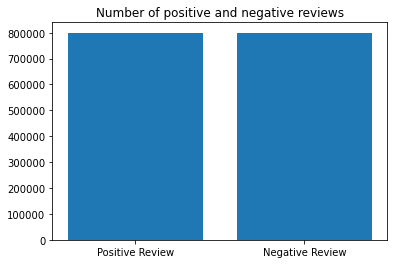

In [10]:
plt.bar(['Positive Review','Negative Review'], [len(data[data['class']==0]),len(data[data['class']==1])], align='center')
plt.title("Number of positive and negative reviews")
#plt.xticks("Positive Review", "Negative Review", rotation=90 )
plt.show()


In [11]:
# count a word in the whole corpas

cellEnabled = 0
if cellEnabled:
    print(" ".join(data["review"]).split(" ").count("werent"))


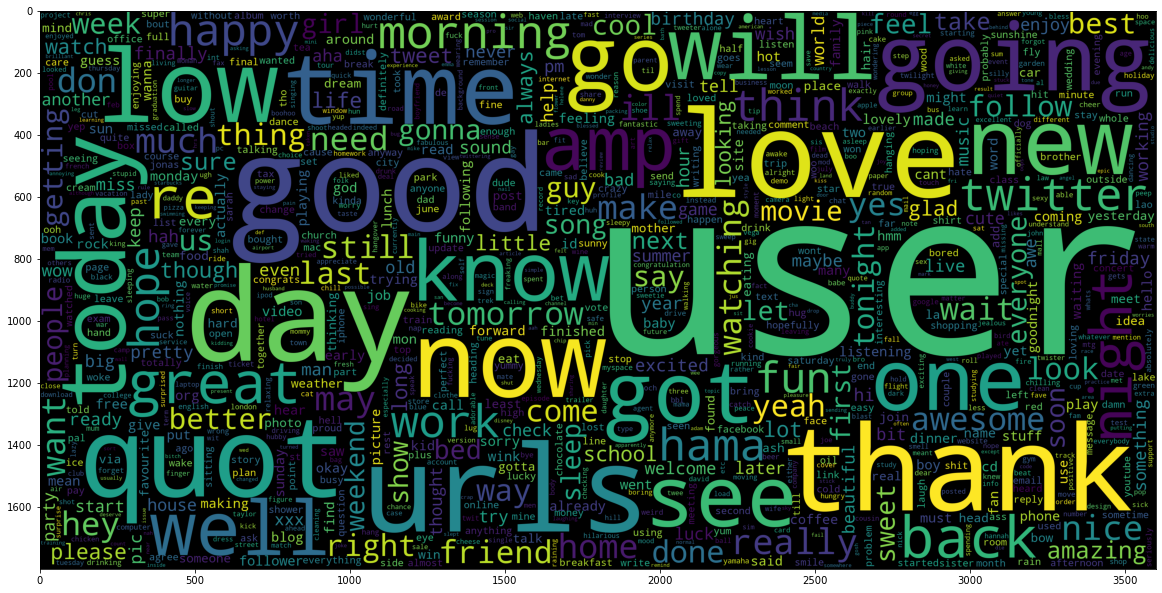

In [12]:
cellEnabled = 1

if cellEnabled:
    data_positive = data_all.tail(cut_off)["review"]
    wc = WordCloud(max_words = 1000 , width = 3600 , height = 1800,
                  collocations=False).generate(" ".join(data_positive))
    plt.figure(figsize = (20,20))
    plt.imshow(wc)

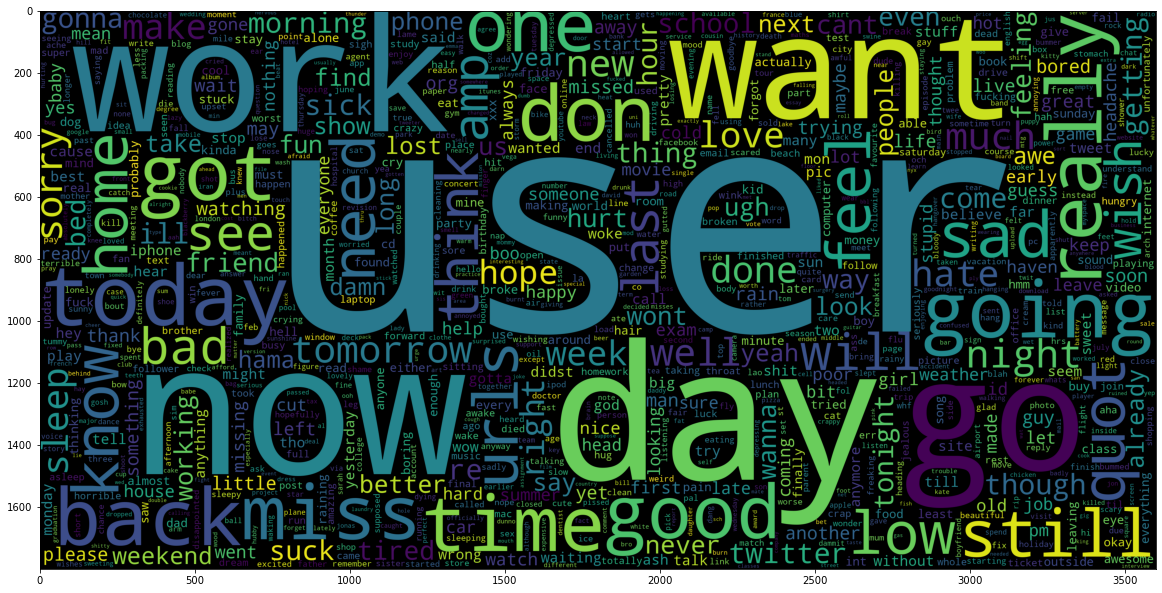

In [13]:
cellEnabled = 1

if cellEnabled:
    data_negative = data_all.head(cut_off)["review"]
    wc = WordCloud(max_words = 1000 , width = 3600 , height = 1800,
                  collocations=False).generate(" ".join(data_negative))
    plt.figure(figsize = (20,20))
    plt.imshow(wc)

### Split Data to Test_set, Traing_set, Features and Target

In [14]:
# Next, we will separate the columns that contain text reviews and the column containing sentiment labels:
X = data["review"] # extract column with reviews

# Convert to binary classification
if 4 in set(data["class"]):
    data["class"] = np.where(data["class"] == 4, 1, 0)
    
y = data["class"] # extract column with sentiments

# split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

## Feature Engineering

### Count Vectors as features

In [15]:
# create a count vectorizer object
count_vect = CountVectorizer(token_pattern = r'\w{1,}')

# Learn a vocabulary dictionary of all tokens in the raw documents
count_vect.fit(data['review'])

# Transform3q documents to document-term matrix.
X_train_count = count_vect.transform(X_train)
X_test_count = count_vect.transform(X_test)

### TF-IDF Vectors as features
- Word level
- N-Gram level
- Character level

In [16]:
%%time
# word level tf-idf
tfidf_vect = TfidfVectorizer(analyzer = 'word',
                             token_pattern = r'\w{1,}',
                             max_features = 500000)
print(tfidf_vect)

tfidf_vect.fit(data['review'])
X_train_tfidf = tfidf_vect.transform(X_train)
X_test_tfidf  = tfidf_vect.transform(X_test)

TfidfVectorizer(max_features=500000, token_pattern='\\w{1,}')
CPU times: user 32.4 s, sys: 733 ms, total: 33.1 s
Wall time: 33.2 s


In [17]:
%%time
# ngram level tf-idf
tfidf_vect_ngram = TfidfVectorizer(analyzer = 'word',
                                   token_pattern = r'\w{1,}',
                                   ngram_range = (2, 3),
                                   max_features = 500000)
print(tfidf_vect_ngram)

tfidf_vect_ngram.fit(data['review'])
X_train_tfidf_ngram = tfidf_vect_ngram.transform(X_train)
X_test_tfidf_ngram  = tfidf_vect_ngram.transform(X_test)

TfidfVectorizer(max_features=500000, ngram_range=(2, 3),
                token_pattern='\\w{1,}')
CPU times: user 2min 20s, sys: 2.79 s, total: 2min 23s
Wall time: 2min 23s


In [18]:
## Modelling%%time
# characters level tf-idf
tfidf_vect_ngram_chars = TfidfVectorizer(analyzer = 'char',
                                         token_pattern = r'\w{1,}',
                                         ngram_range = (2, 3),
                                         max_features = 500000)
print(tfidf_vect_ngram_chars)

tfidf_vect_ngram_chars.fit(data['review'])
X_train_tfidf_ngram_chars = tfidf_vect_ngram_chars.transform(X_train)
X_test_tfidf_ngram_chars  = tfidf_vect_ngram_chars.transform(X_test)

TfidfVectorizer(analyzer='char', max_features=500000, ngram_range=(2, 3),
                token_pattern='\\w{1,}')


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:501: UserWarning: The parameter 'token_pattern' will not be used since 'analyzer' != 'word'
  warnings.warn("The parameter 'token_pattern' will not be used"


## Modelling

In [19]:
def train_model(classifier, feature_vector_train, label, feature_vector_valid):
    # fit the training dataset on the classifier
    classifier.fit(feature_vector_train, label)

    # predict the labels on validation dataset
    predictions = classifier.predict(feature_vector_valid)

    return accuracy_score(predictions, y_test)

In [20]:
# Keep the results in a dataframe
results = pd.DataFrame(columns = ['Count Vectors',
                                  'WordLevel TF-IDF',
                                  'N-Gram Vectors',
                                  'CharLevel Vectors',
                                 'Pretrained GloVe200'])

### Naive bayes

In [21]:
# Naive Bayes on Count Vectors
accuracy1 = train_model(MultinomialNB(), X_train_count, y_train, X_test_count)
print('NB, Count Vectors    : %.4f\n' % accuracy1)

NB, Count Vectors    : 0.7779



In [22]:
results.loc['Naive bayes'] = {
    'Count Vectors': accuracy1,
    'WordLevel TF-IDF': "-",
    'N-Gram Vectors': "-",
    'CharLevel Vectors': "-",
    'Pretrained GloVe200': "-"}

### LogisticRegression

In [23]:
%%time
# Linear Classifier on Word Level TF IDF Vectors
accuracy2 = train_model(LogisticRegression(solver = 'lbfgs', max_iter = 5000), X_train_tfidf, y_train, X_test_tfidf)
print('LR, WordLevel TF-IDF : %.4f\n' % accuracy2)

LR, WordLevel TF-IDF : 0.7954

CPU times: user 12min 14s, sys: 3min 19s, total: 15min 34s
Wall time: 1min 11s


In [24]:
%%time
# Linear Classifier on Ngram Level TF IDF Vectors
accuracy3 = train_model(LogisticRegression(solver = 'lbfgs', max_iter = 5000), X_train_tfidf_ngram, y_train, X_test_tfidf_ngram)
print('LR, N-Gram Vectors   : %.4f\n' % accuracy3)

LR, N-Gram Vectors   : 0.8087

CPU times: user 6min 12s, sys: 1min 20s, total: 7min 33s
Wall time: 45.1 s


In [25]:
%%time
# Linear Classifier on Character Level TF IDF Vectors
accuracy4 = train_model(LogisticRegression(solver = 'lbfgs', max_iter = 5000), X_train_tfidf_ngram_chars, y_train, X_test_tfidf_ngram_chars)
print('LR, CharLevel Vectors: %.4f\n' % accuracy4)

LR, CharLevel Vectors: 0.7779

CPU times: user 14min 33s, sys: 2min 43s, total: 17min 17s
Wall time: 3min 6s


In [26]:
results.loc['Logistic Regression'] = {
    'Count Vectors': "-",
    'WordLevel TF-IDF': accuracy2,
    'N-Gram Vectors': accuracy3,
    'CharLevel Vectors': accuracy4,
    'Pretrained GloVe200': "-"}

In [27]:
results

,Count Vectors,WordLevel TF-IDF,N-Gram Vectors,CharLevel Vectors,Pretrained GloVe200
Naive bayes,0.777853,-,-,-,-
Logistic Regression,-,0.795406,0.808656,0.777853,-


### Support Vector Machine

In [28]:
%%time
# Support Vector Machine on Count Vectors
accuracy1 = train_model(LinearSVC(max_iter = 5000), X_train_count, y_train, X_test_count)
print('SVM, Count Vectors    : %.4f\n' % accuracy1)

SVM, Count Vectors    : 0.7896

CPU times: user 31min 27s, sys: 3.3 s, total: 31min 30s
Wall time: 31min 32s


/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


In [29]:
%%time
# Support Vector Machine on Word Level TF IDF Vectors
accuracy2 = train_model(LinearSVC(), X_train_tfidf, y_train, X_test_tfidf)
print('SVM, WordLevel TF-IDF : %.4f\n' % accuracy2)

SVM, WordLevel TF-IDF : 0.7920

CPU times: user 23.7 s, sys: 55.5 ms, total: 23.8 s
Wall time: 23.8 s


In [30]:
%%time
# Support Vector Machine on Ngram Level TF IDF Vectors
accuracy3 = train_model(LinearSVC(), X_train_tfidf_ngram, y_train, X_test_tfidf_ngram)
print('SVM, N-Gram Vectors   : %.4f\n' % accuracy3)

SVM, N-Gram Vectors   : 0.7969

CPU times: user 22.3 s, sys: 130 ms, total: 22.5 s
Wall time: 22.5 s


In [31]:
%%time
# Support Vector Machine on Character Level TF IDF Vectors
accuracy4 = train_model(LinearSVC(), X_train_tfidf_ngram_chars, y_train, X_test_tfidf_ngram_chars)
print('SVM, CharLevel Vectors: %.4f\n' % accuracy4)

SVM, CharLevel Vectors: 0.7786

CPU times: user 44.1 s, sys: 769 ms, total: 44.9 s
Wall time: 44.9 s


In [32]:
results.loc['Support Vector Machine'] = {
    'Count Vectors': accuracy1,
    'WordLevel TF-IDF': accuracy2,
    'N-Gram Vectors': accuracy3,
    'CharLevel Vectors': accuracy4,
    'Pretrained GloVe200': "-"}

In [33]:
results

,Count Vectors,WordLevel TF-IDF,N-Gram Vectors,CharLevel Vectors,Pretrained GloVe200
Naive bayes,0.777853,-,-,-,-
Logistic Regression,-,0.795406,0.808656,0.777853,-
Support Vector Machine,0.789631,0.792031,0.796928,0.778575,-


### Word Embedding

In [34]:
y_train=to_categorical(y_train)
y_test=to_categorical(y_test)


In [35]:
embeddings_index = {}
d=1
with open("glove.6B.300d.txt") as f:
    for line in f:
        d=d+1
        if d<6:
            word, coefs = line.split(maxsplit=1)
            #print(coefs)
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

print("Found %s word vectors." % len(embeddings_index))

Found 400000 word vectors.


In [36]:
embeddings_index["king"]

array([ 0.0033901, -0.34614  ,  0.28144  ,  0.48382  ,  0.59469  ,
        0.012965 ,  0.53982  ,  0.48233  ,  0.21463  , -1.0249   ,
       -0.34788  , -0.79001  , -0.15084  ,  0.61374  ,  0.042811 ,
        0.19323  ,  0.25462  ,  0.32528  ,  0.05698  ,  0.063253 ,
       -0.49439  ,  0.47337  , -0.16761  ,  0.045594 ,  0.30451  ,
       -0.35416  , -0.34583  , -0.20118  ,  0.25511  ,  0.091111 ,
        0.014651 , -0.017541 , -0.23854  ,  0.48215  , -0.9145   ,
       -0.36235  ,  0.34736  ,  0.028639 , -0.027065 , -0.036481 ,
       -0.067391 , -0.23452  , -0.13772  ,  0.33951  ,  0.13415  ,
       -0.1342   ,  0.47856  , -0.1842   ,  0.10705  , -0.45834  ,
       -0.36085  , -0.22595  ,  0.32881  , -0.13643  ,  0.23128  ,
        0.34269  ,  0.42344  ,  0.47057  ,  0.479    ,  0.074639 ,
        0.3344   ,  0.10714  , -0.13289  ,  0.58734  ,  0.38616  ,
       -0.52238  , -0.22028  , -0.072322 ,  0.32269  ,  0.44226  ,
       -0.037382 ,  0.18324  ,  0.058082 ,  0.26938  ,  0.3620

In [37]:
#embeddings_index["studies"] # no neeed for stemming or lemmatizing

In [38]:
from tensorflow.keras.layers import TextVectorization

#vectorizer = TextVectorization(max_tokens=100000, output_sequence_length=200)
vectorizer = TextVectorization(output_sequence_length=140)
text_ds = tf.data.Dataset.from_tensor_slices(X_train).batch(512)
vectorizer.adapt(text_ds)

In [39]:
vectorizer.get_vocabulary()[:5]

['', '[UNK]', 'i', 'a', 'user']

In [40]:
voc = vectorizer.get_vocabulary()
word_index = dict(zip(voc, range(len(voc))))

In [42]:
len(voc)

56288

In [44]:
# source: https://keras.io/examples/nlp/pretrained_word_embeddings/
num_tokens = len(voc) + 2
embedding_dim = 300
hits = 0
misses = 0
vie=[]
vnie=[]

# Prepare embedding matrix
embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"
        embedding_matrix[i] = embedding_vector
        vie.append(word)
        hits += 1
    else:
        misses += 1
        vnie.append(word)
print("Converted %d words (%d misses)" % (hits, misses))

Converted 52917 words (3371 misses)


([<matplotlib.axis.XTick at 0x7feab0053880>,
 [Text(0, 0, 'Pretrained GloVe'),
  Text(0, 0, 'Total in Twitter'),
  Text(0, 0, 'Converted'),
  Text(0, 0, 'Unused')])

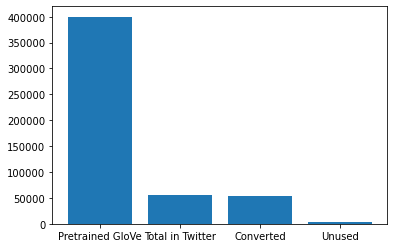

In [92]:
vocabulary = {
    'Pretrained GloVe': 400000,
    'Total in Twitter':len(voc),
    'Converted': hits,
    'Unused': misses}


plt.bar(range(len(vocabulary)), list(vocabulary.values()), align='center')
plt.xticks(range(len(vocabulary)), list(vocabulary.keys()))

In [45]:
vnie[:100]# not used in embedded layer

['',
 '[UNK]',
 '\ufeffthe',
 'boohoo',
 'shouldnt',
 'hols',
 'kkt',
 'mcflyforgermany',
 'girlies',
 'werent',
 'pizz',
 'tyg',
 'couldve',
 'yest',
 'shits',
 'woops',
 'jav',
 'shouldve',
 'feck',
 'arsed',
 'mho',
 'titties',
 'shitting',
 'happybdaykrisallen',
 'buggered',
 'nowt',
 'pwned',
 'vocab',
 'geog',
 'estop',
 'innit',
 'farted',
 'shitload',
 'crapped',
 'pressie',
 'dunt',
 'geddit',
 'achoo',
 'stargaze',
 'hgt',
 'hahahahahahaha',
 'motherfucking',
 'astr',
 'jonasliveonfb',
 'fth',
 'twats',
 'dins',
 'washin',
 'souljaboytellem',
 'shittiest',
 'impf',
 'fraps',
 'besom',
 'rayban',
 'mtvmovieawards',
 'halloo',
 'bubs',
 'theyll',
 'sodding',
 'dannygokeyislove',
 'wankers',
 'summat',
 'randoms',
 'pwns',
 'prezzies',
 'pressies',
 'contd',
 'wmk',
 'anthrop',
 'twinks',
 'pussies',
 'crapping',
 'qty',
 'mawkin',
 'crappiest',
 'tatted',
 'oho',
 'bowwow',
 'req',
 'mams',
 'bitt',
 'walkies',
 'thingsmummysaid',
 'theyve',
 'pervs',
 'ohnotheydidnt',
 'regex'

In [46]:
from tensorflow.keras.layers import Embedding

embedding_layer = Embedding(
    num_tokens,
    embedding_dim,
    embeddings_initializer=keras.initializers.Constant(embedding_matrix),
    trainable=False,
)


### Neural Network

In [47]:
from tensorflow.keras import layers

int_sequences_input = keras.Input(shape=(None,), dtype="int64")

embedded_sequences = embedding_layer(int_sequences_input)
x = layers.Conv1D(128, 5, activation="relu")(embedded_sequences)
x = layers.MaxPooling1D(5)(x)
#x = layers.Conv1D(128, 5, activation="relu")(x)
#x = layers.MaxPooling1D(5)(x)
x = layers.Conv1D(128, 5, activation="relu")(x)
x = layers.GlobalMaxPooling1D()(x)
x = layers.Dense(128, activation="relu")(x)
x = layers.Dropout(0.5)(x)
preds = layers.Dense(len(set(y)), activation="softmax")(x)
model = keras.Model(int_sequences_input, preds)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding (Embedding)       (None, None, 300)         16887000  
                                                                 
 conv1d (Conv1D)             (None, None, 128)         192128    
                                                                 
 max_pooling1d (MaxPooling1D  (None, None, 128)        0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, None, 128)         82048     
                                                                 
 global_max_pooling1d (Globa  (None, 128)              0         
 lMaxPooling1D)                                              

In [48]:
X_train = vectorizer(np.array([[s] for s in X_train])).numpy()
X_test = vectorizer(np.array([[s] for s in X_test])).numpy()

y_train = np.array(y_train)
y_test = np.array(y_test)

In [49]:
X_test.shape

(320000, 140)

In [50]:
'''model.compile(
    loss="sparse_categorical_crossentropy", optimizer="rmsprop", metrics=["acc"]
)'''
'''model.compile(
    loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["acc"]
)'''
model.compile(
    loss="binary_crossentropy", optimizer="adam", metrics=["acc"])

In [51]:
history=model.fit(X_train, y_train, batch_size=512, epochs=6, validation_data=(X_test, y_test))

Epoch 1/6
2500/2500 [==============================] - 550s 220ms/step - loss: 0.4489 - acc: 0.7898 - val_loss: 0.4185 - val_acc: 0.8061
Epoch 2/6
2500/2500 [==============================] - 512s 205ms/step - loss: 0.4062 - acc: 0.8151 - val_loss: 0.4105 - val_acc: 0.8108
Epoch 3/6
2500/2500 [==============================] - 508s 203ms/step - loss: 0.3887 - acc: 0.8241 - val_loss: 0.4037 - val_acc: 0.8143
Epoch 4/6
2500/2500 [==============================] - 504s 202ms/step - loss: 0.3757 - acc: 0.8311 - val_loss: 0.4021 - val_acc: 0.8164
Epoch 5/6
2500/2500 [==============================] - 502s 201ms/step - loss: 0.3650 - acc: 0.8366 - val_loss: 0.4059 - val_acc: 0.8143
Epoch 6/6
2500/2500 [==============================] - 504s 202ms/step - loss: 0.3554 - acc: 0.8415 - val_loss: 0.4082 - val_acc: 0.8147


In [52]:
score = model.evaluate(X_test, y_test,verbose = 0)

In [53]:
score

[0.40816524624824524, 0.8147218823432922]

In [54]:
results.loc['Neural network'] = {
    'Count Vectors': "-",
    'WordLevel TF-IDF':"-",
    'N-Gram Vectors': "-",
    'CharLevel Vectors': "-",
    'Pretrained GloVe200': score[1]}

In [55]:
results

,Count Vectors,WordLevel TF-IDF,N-Gram Vectors,CharLevel Vectors,Pretrained GloVe200
Naive bayes,0.777853,-,-,-,-
Logistic Regression,-,0.795406,0.808656,0.777853,-
Support Vector Machine,0.789631,0.792031,0.796928,0.778575,-
Neural network,-,-,-,-,0.814722


dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])


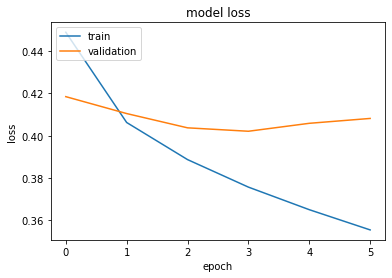

In [56]:
# insert code here
# insert code here
print(history.history.keys())
# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])


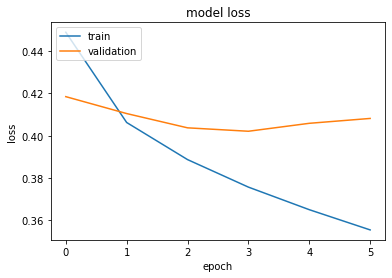

In [57]:
# insert code here
# insert code here
print(history.history.keys())
# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

### Bidirectional LSTM

In [58]:
from keras.models import Sequential
from keras.layers import SimpleRNN, Flatten, TimeDistributed, LSTM, Dense, Bidirectional,Dropout

model=Sequential()
model.add(embedding_layer)
#model.add(LSTM(128,input_shape=(5,10)))
#model.add(Bidirectional(LSTM(128, return_sequences=True)))
model.add(Bidirectional(LSTM(128)))
#model.add(LSTM(128, return_sequences=True))
#model.add(LSTM(128))
model.add(Dense(64,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(32,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(2,activation='sigmoid'))
model.build()
model.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 300)         16887000  
                                                                 
 bidirectional (Bidirectiona  (None, 256)              439296    
 l)                                                              
                                                                 
 dense_2 (Dense)             (None, 64)                16448     
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 32)                2080      
                                                                 
 dropout_2 (Dropout)         (None, 32)                0         
                                                        

In [59]:
%%time
# insert code here
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["acc"])


CPU times: user 3.52 ms, sys: 878 µs, total: 4.4 ms
Wall time: 3.56 ms


In [60]:
%load_ext tensorboard
#%tensorboard --logdir logs

In [61]:
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

#history=model.fit(X_train, y_train, batch_size=128, epochs=3, validation_data=(X_test, y_test))
#history=model.fit(X_train, y_train, batch_size=512, epochs=5, validation_data=(X_test, y_test))
history=model.fit(X_train, y_train, batch_size=512, epochs=8, validation_data=(X_test, y_test),callbacks=[tensorboard_callback])


Epoch 1/8
2500/2500 [==============================] - 2557s 1s/step - loss: 0.4602 - acc: 0.7883 - val_loss: 0.4085 - val_acc: 0.8127
Epoch 2/8
2500/2500 [==============================] - 2551s 1s/step - loss: 0.4095 - acc: 0.8178 - val_loss: 0.3911 - val_acc: 0.8217
Epoch 3/8
2500/2500 [==============================] - 2493s 997ms/step - loss: 0.3919 - acc: 0.8273 - val_loss: 0.3856 - val_acc: 0.8252
Epoch 4/8
2500/2500 [==============================] - 2504s 1s/step - loss: 0.3801 - acc: 0.8334 - val_loss: 0.3856 - val_acc: 0.8252
Epoch 5/8
2500/2500 [==============================] - 2504s 1s/step - loss: 0.3705 - acc: 0.8387 - val_loss: 0.3816 - val_acc: 0.8282
Epoch 6/8
2500/2500 [==============================] - 2574s 1s/step - loss: 0.3618 - acc: 0.8426 - val_loss: 0.3835 - val_acc: 0.8253
Epoch 7/8
2500/2500 [==============================] - 2522s 1s/step - loss: 0.3536 - acc: 0.8463 - val_loss: 0.3825 - val_acc: 0.8295
Epoch 8/8
2500/2500 [==============================]

In [62]:
score= model.evaluate(X_test, y_test,verbose = 0)

In [63]:
score

[0.3846207857131958, 0.8304250240325928]

In [64]:
results.loc['Bidirectional LSTM'] = {
    'Count Vectors': "-",
    'WordLevel TF-IDF':"-",
    'N-Gram Vectors': "-",
    'CharLevel Vectors': "-",
    'Pretrained GloVe200': score[1]}

### Training Statistics

In [65]:
%tensorboard --logdir logs --host localhost

### Presenting Results

In [66]:
results

,Count Vectors,WordLevel TF-IDF,N-Gram Vectors,CharLevel Vectors,Pretrained GloVe200
Naive bayes,0.777853,-,-,-,-
Logistic Regression,-,0.795406,0.808656,0.777853,-
Support Vector Machine,0.789631,0.792031,0.796928,0.778575,-
Neural network,-,-,-,-,0.814722
Bidirectional LSTM,-,-,-,-,0.830425


### ROC Curve

In [67]:
y_preds= model.predict(X_train)

In [68]:
y_preds

array([[0.18462312, 0.8153769 ],
       [0.7299796 , 0.27002043],
       [0.03346658, 0.9665334 ],
       ...,
       [0.80621386, 0.19378608],
       [0.5720539 , 0.4279461 ],
       [0.80394495, 0.19605505]], dtype=float32)

In [69]:
y_p=y_preds.ravel()

In [70]:
y_t=np.argmax(y_train,axis=1)
#y_p = np.where(y_preds > 0.5, 1, 0)

In [71]:
y_t=y_train.ravel()

In [72]:
y_p

array([0.18462312, 0.8153769 , 0.7299796 , ..., 0.4279461 , 0.80394495,
       0.19605505], dtype=float32)

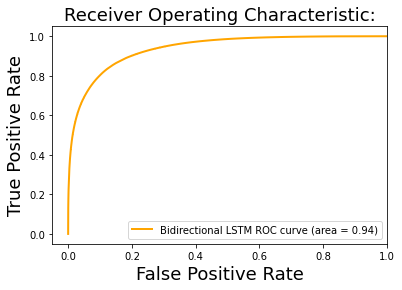

'Accuracy is computed at the threshold value of 0.5. \nWhile AUC is computed by adding all the "accuracies" computed \nfor all the possible threshold values. ROC can be seen as an average \n(expected value) of those accuracies when are computed for all threshold values.'

In [87]:
#y_t=np.argmax(y_train,axis=1)
#y_p = np.where(y_preds > 0.5, 1, 0)
#y_p=np.argmax(y_p, axis=1)
fpr, tpr, thresholds = metrics.roc_curve(y_t, y_p)
roc_auc = metrics.auc(fpr, tpr)
plt.plot(fpr, tpr, color='orange', lw = 2, label = '%s ROC curve (area = %0.2f)' % ('Bidirectional LSTM',roc_auc))
plt.xlim([-0.05, 1.0])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
plt.title('Receiver Operating Characteristic:', fontsize=18)
plt.legend(loc="lower right")
plt.show()

# Why ROC curve area is different than accuracy
'''Accuracy is computed at the threshold value of 0.5. 
While AUC is computed by adding all the "accuracies" computed 
for all the possible threshold values. ROC can be seen as an average 
(expected value) of those accuracies when are computed for all threshold values.'''
# https://stats.stackexchange.com/questions/90659/why-is-auc-higher-for-a-classifier-that-is-less-accurate-than-for-one-that-is-mo

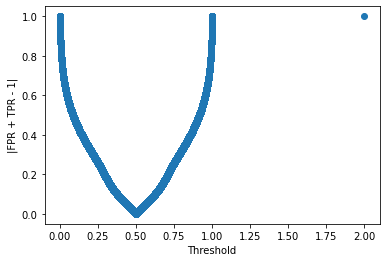

In [74]:
#https://www.yourdatateacher.com/2021/06/14/are-you-still-using-0-5-as-a-threshold/

plt.scatter(thresholds,np.abs(fpr+tpr-1))
plt.xlabel("Threshold")
plt.ylabel("|FPR + TPR - 1|")
plt.show()

In [75]:
# best threshold close to 0.5 make sense as our model trained based on 0.5 threshold

thresholds[np.argmin(np.abs(fpr+tpr-1))]

0.5000008

### Evaluate

In [76]:

def evaluate(model,X,X_train, X_test, y, y_train, y_test):
    
    y_test=np.argmax(y_test,axis=1)
    y_train=np.argmax(y_train,axis=1)


    y_pred_class_training = model.predict(X_train)
    y_pred_class_training = np.where(y_pred_class_training > 0.5, 1, 0)
    y_pred_class_training=np.argmax(y_pred_class_training,axis=1)
    training_accuracy_score=metrics.accuracy_score(y_train,y_pred_class_training)
    print("Training Accuracy Score:\n",training_accuracy_score )
    
    
    y_pred_class_test = model.predict(X_test)
    y_pred_class_test = np.where(y_pred_class_test > 0.5, 1, 0)
    y_pred_class_test=np.argmax(y_pred_class_test,axis=1)
    test_accuracy_score=metrics.accuracy_score(y_test,y_pred_class_test)
    print("Test Accuracy Score:\n", test_accuracy_score)
    
    print("confusion_matrix:\n",metrics.confusion_matrix(y_test, y_pred_class_test))
    print("classification_report:\n",metrics.classification_report(y_test, y_pred_class_test))
    return training_accuracy_score,test_accuracy_score

In [77]:
evaluate(model,X,X_train, X_test, y, y_train, y_test)

Training Accuracy Score:
 0.85718671875
Test Accuracy Score:
 0.830425
confusion_matrix:
 [[134899  24595]
 [ 29669 130837]]
classification_report:
               precision    recall  f1-score   support

           0       0.82      0.85      0.83    159494
           1       0.84      0.82      0.83    160506

    accuracy                           0.83    320000
   macro avg       0.83      0.83      0.83    320000
weighted avg       0.83      0.83      0.83    320000



(0.85718671875, 0.830425)

### Deployment

In [94]:
def inference(review):

    df = pd.DataFrame([[review]], columns=['review'])
    df["review"]=df["review"].apply(preprocessing_main)
    df_test = vectorizer(np.array([[s] for s in df["review"]])).numpy()

    prd_r=model.predict(df_test)
    prd = np.where(prd_r > 0.5, 1, 0)
    prd=np.argmax(prd,axis=1)
    if prd[0]==0:
        res='This is a Negative Review, Score: '+str(round(prd_r[0][1]*10))+"/10"
    else:
        res='This is a Positive Review, Score: '+str(round(prd_r[0][1]*10))+"/10"
       
    return res


review=gr.inputs.Textbox(lines=2, label="Review", placeholder="Write your review here...")

gr.Interface(inference, [review], "label", live=False).launch(share=True) #, debug=True Use in Colab

Running on local URL:  http://127.0.0.1:7865/
Running on public URL: https://45862.gradio.app

This share link expires in 72 hours. For free permanent hosting, check out Spaces (https://huggingface.co/spaces)


(<fastapi.applications.FastAPI at 0x7fefd3ee6ee0>,
 'http://127.0.0.1:7865/',
 'https://45862.gradio.app')

2022-06-03 09:26:43,406 ERROR:Socket exception: Connection reset by peer (54)
